# Лабораторная работа №4

In [ ]:
# Loading extension for reloading editable packages (pip install -e .)
%load_ext autoreload

In [ ]:
# Reloading editable packages.
%autoreload
# from lab1.main import get_results

Вариант:
1. Номер группы + 15 = 2 + 15 = 17
2. Номер варианта + 56 = 14 + 56 = 70
3. ИУ5 (Номер варианта + 21) = 14 + 21 = 35

In [1]:
import pickle
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from numpy.typing import ArrayLike
from PIL import Image
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Классификация изображений CIFAR100 с использованием переноса обучения с ResNet
### Загрузка и распаковка набора данных CIFAR100

In [3]:
import os  # noqa
import shutil  # noqa
import urllib  # noqa
from pathlib import Path  # noqa

url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
filename = "cifar-100-python.tar.gz"
model_path = Path("data")

model_path.mkdir(exist_ok=True)

file_path = model_path / filename

if not os.path.isfile(file_path):
    urllib.request.urlretrieve(url, file_path)
    shutil.unpack_archive(file_path, extract_dir=model_path)
    file_path.unlink()  # Remove archive after extracting it.

### Чтение тренировочной и тестовой выборки

In [4]:
def stem_extensions(filename: Path):
    extensions = "".join(filename.suffixes)

    return str(filename).removesuffix(extensions)

In [5]:
dataset_path = Path(stem_extensions(file_path))

with open(dataset_path / "train", "rb") as f:
    data_train = pickle.load(f, encoding="latin1")
with open(dataset_path / "test", "rb") as f:
    data_test = pickle.load(f, encoding="latin1")

# Классы по варианту.
CLASSES = [17, 70, 35]

train_X_raw = data_train["data"].reshape(-1, 3, 32, 32)
train_X_raw = np.transpose(train_X_raw, [0, 2, 3, 1])  # NCHW -> NHWC
train_y_raw = np.array(data_train["fine_labels"])
mask = np.isin(train_y_raw, CLASSES)
train_X = train_X_raw[mask].copy()
train_y = train_y_raw[mask].copy()
train_y = np.unique(train_y, return_inverse=1)[1]
del data_train

test_X = data_test["data"].reshape(-1, 3, 32, 32)
test_X = np.transpose(test_X, [0, 2, 3, 1])
test_y = np.array(data_test["fine_labels"])
mask = np.isin(test_y, CLASSES)
test_X = test_X[mask].copy()
test_y = test_y[mask].copy()
test_y = np.unique(test_y, return_inverse=1)[1]
del data_test

# print(train_y_raw.tolist())

In [6]:
def createImage(data: ArrayLike):
    return Image.fromarray(data).resize((256, 256))

In [7]:
# Source: https://stackoverflow.com/a/47334314
def grid_display(list_of_images, list_of_titles=[], no_of_columns=2, figsize=(10, 10)):
    fig = plt.figure(figsize=figsize)
    column = 0
    for i in range(len(list_of_images)):
        column += 1
        #  check for end of column and create a new figure
        if column == no_of_columns + 1:
            fig = plt.figure(figsize=figsize)
            column = 1
        fig.add_subplot(1, no_of_columns, column)
        plt.imshow(list_of_images[i])
        plt.axis("off")
        if len(list_of_titles) >= len(list_of_images):
            plt.title(list_of_titles[i])

class_id = 17:


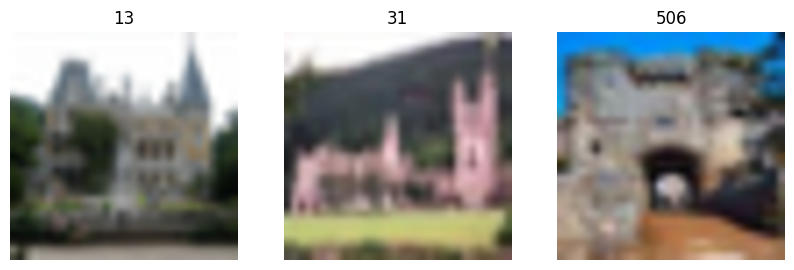

class_id = 70:


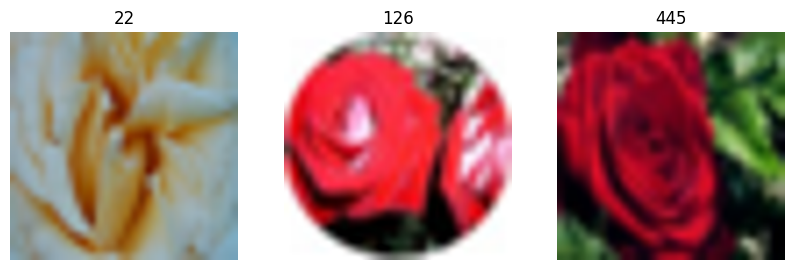

class_id = 35:


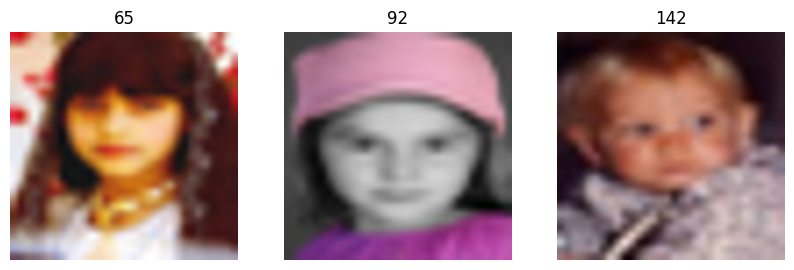

In [8]:
# По 3 экземпляра класса из выборки.
number_of_images_per_class_to_show = 3

for class_id in CLASSES:
    print(f"{class_id = }:")
    i = number_of_images_per_class_to_show
    image_index_for_class = -1
    class_images = []
    image_indices = []

    while i > 0:
        image_index_for_class = train_y_raw.tolist().index(
            class_id, image_index_for_class + 1
        )
        image_indices.append(image_index_for_class)
        class_images.append(createImage(train_X_raw[image_index_for_class]))
        i -= 1
    grid_display(class_images, image_indices, number_of_images_per_class_to_show)
    plt.show()

### Создание Cifar Dataset с аугментацией

In [10]:
from torch import Tensor  # noqa
from torch.utils.data import Dataset  # noqa


class CifarDataset(Dataset):
    def __init__(self, X: Tensor, y: Tensor, transform=None, p=0.0):
        assert X.size(0) == y.size(0)
        super(Dataset, self).__init__()
        self.X = X
        self.y = y
        self.transform = transform
        self.prob = p

    def __len__(self):
        return self.y.size(0)

    def __getitem__(self, index):
        X = self.X[index]
        if self.transform and np.random.random() < self.prob:
            X = self.transform(X.permute(2, 0, 1) / 255).permute(1, 2, 0) * 255

        y = self.y[index]

        return X, y

Попробуем применить аугментацию к одной из картинок.

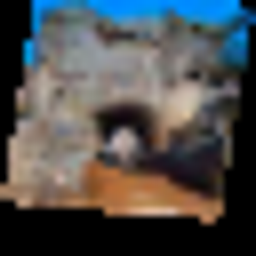

In [11]:
import torchvision.transforms as T  # noqa

transform = T.Compose(
    [
        T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2, hue=0.0),
        # shear - сдвиг.
        T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=15),
    ]
)

Image.fromarray(
    (CifarDataset(Tensor(train_X), Tensor(train_y), transform=transform, p=1)[10])[0]
    .numpy()
    .astype(np.uint8)
).resize((256, 256))

### Создание Pytorch DataLoader'a

In [12]:
def create_dataloader(batch_size=128):
    dataloader: dict[str, DataLoader] = {}
    for (X, y), part in zip([(train_X, train_y), (test_X, test_y)], ["train", "test"]):
        tensor_x = torch.Tensor(X)
        tensor_y = (
            F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(CLASSES)) / 1.0
        )
        dataset = CifarDataset(
            tensor_x, tensor_y, transform=transform if part == "train" else None, p=0.5
        )  # создание объекта датасета
        dataloader[part] = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True,
            # prefetch_factor=8 if part == "train" else 2,
            # num_workers=2,
            # persistent_workers=True,
        )  # создание экземпляра класса DataLoader

    return dataloader

### Создание Pytorch модели свёрточной нейронной сети

In [37]:
HIDDEN_SIZE = 64


class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2)  # nhwc -> nm


model = torch.hub.load(
    "chenyaofo/pytorch-cifar-models", "cifar100_resnet20", pretrained=True
)
model.to(device)
new_model = nn.Sequential(
    # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025]),
    model,
).to(device)
# Test run of model with noise input.
# print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

Using cache found in /Users/aspakalo/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

### Создание логов для Tensorboard

In [38]:
import time  # noqa

from torch.utils.tensorboard import SummaryWriter  # noqa

%load_ext tensorboard

current_time = str(int(time.time()))

run_path = Path("runs/tensorboard")

train_run_path = run_path / "train" / current_time
test_run_path = run_path / "test" / current_time

train_summary_writer = SummaryWriter(log_dir=train_run_path)
test_summary_writer = SummaryWriter(log_dir=test_run_path)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Перенос обучения
Обучим нашу модель сначала с заморозкой, затем полностью с разморозкой.

In [39]:
def compute_RF_numerical(net, img_np):
    """
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks,
      it must be full of ones and with the correct
    shape.
    """

    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)

    # net.apply(weights_init)
    img_ = torch.tensor(torch.from_numpy(img_np).float(), requires_grad=True)
    out_cnn = net(img_.to(device))
    out_shape = out_cnn.size()
    ndims = len(out_cnn.size())
    grad = torch.zeros(out_cnn.size())
    l_tmp = []
    for i in range(ndims):
        if i == 0 or i == 1:  # batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i] / 2)

    grad[tuple(l_tmp)] = 1
    out_cnn.backward(gradient=grad.to(device))
    grad_np = img_.grad[0, 0].data.detach().cpu().numpy()
    idx_nonzeros = np.where(grad_np != 0)
    RF = [np.max(idx) - np.min(idx) + 1 for idx in idx_nonzeros]

    return RF


compute_RF_numerical(model, np.zeros((1, 3, 1024, 1024)))

/var/folders/68/lshvxyd918l6zzmw21cyp43cs2g63g/T/ipykernel_96312/1966411608.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_ = torch.tensor(torch.from_numpy(img_np).float(), requires_grad=True)


[1024, 1024]

### Замена полносвязного слоя

In [40]:
in_features = new_model[1].fc.in_features
new_model[1].fc = nn.Linear(
    in_features=in_features, out_features=len(CLASSES), bias=True
)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

### Заморозка весов

In [42]:
print("Обучаемые параметры:")


def freeze(keep_last=2):
    total = len([*new_model.named_parameters()])
    params_to_update = []
    for i, (name, param) in enumerate(new_model.named_parameters()):
        if i < total - keep_last:
            param.requires_grad = False
        else:
            params_to_update.append(param)
            param.requires_grad = True
            print("\t", name)

    return new_model


new_model = freeze(keep_last=5)
summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.layer3.2.conv2.weight
	 1.layer3.2.bn2.weight
	 1.layer3.2.bn2.bias
	 1.fc.weight
	 1.fc.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32] 

### Fine-tuning полносвязного слоя. Обучение модели по эпохам

In [43]:
REDRAW_EVERY = 20
# New: Changed epochs.
EPOCHS = 60


def train(
    model: nn.Module,
    criterion: nn.CrossEntropyLoss,
    optimizer: optim.Optimizer,
    dataloader: dict[str, DataLoader],
    scheduler: optim.lr_scheduler.LRScheduler,
    epochs=EPOCHS,
):
    steps_per_epoch = len(dataloader["train"])
    steps_per_epoch_val = len(dataloader["test"])

    pbar = tqdm(total=epochs * steps_per_epoch)
    losses = []
    losses_val = []
    passed = 0
    # Для создания чекпоинта
    best_acc = 0
    checkpoint_path = Path("cifar_resnet.pth")

    for epoch in range(epochs):  # проход по набору данных несколько раз
        tmp = []
        model.train()
        for i, batch in enumerate(dataloader["train"], 0):
            # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
            inputs, labels = batch

            # очищение прошлых градиентов с прошлой итерации
            optimizer.zero_grad()

            # прямой + обратный проходы + оптимизация
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

            # для подсчёта статистик
            accuracy = (
                labels.detach().argmax(dim=-1) == outputs.detach().argmax(dim=-1)
            ).to(torch.float32).mean().cpu() * 100
            tmp.append((loss.item(), accuracy.item()))
            pbar.update(1)

            with train_summary_writer as writer:
                writer.add_scalar("loss", tmp[-1][0], global_step=pbar.n)
                writer.add_scalar("accuracy", tmp[-1][1], global_step=pbar.n)

        losses.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        scheduler.step()  # Обновляем learning_rate каждую эпоху.

        tmp = []
        model.eval()
        with torch.no_grad():  # отключение автоматического дифференцирования
            for i, data in enumerate(dataloader["test"], 0):
                inputs, labels = data
                # на GPU
                # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                accuracy = (labels.argmax(dim=-1) == outputs.argmax(dim=-1)).to(
                    torch.float32
                ).mean().cpu() * 100
                tmp.append((loss.item(), accuracy.item()))
        losses_val.append(
            (
                np.mean(tmp, axis=0),
                np.percentile(tmp, 25, axis=0),
                np.percentile(tmp, 75, axis=0),
            )
        )
        with test_summary_writer as writer:
            writer.add_scalar("loss", losses_val[-1][0][0], global_step=pbar.n)
            writer.add_scalar("accuracy", losses_val[-1][0][1], global_step=pbar.n)

        acc = losses_val[-1][0][1]
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), checkpoint_path)

        # Обновление графиков.
        if (epoch + 1) % REDRAW_EVERY != 0:
            continue
        clear_output(wait=False)
        print(
            "Эпоха: %s\n"
            "Лучшая доля правильных ответов: %s\n"
            "Текущая доля правильных ответов: %s" % (epoch + 1, best_acc, acc)
        )
        passed += pbar.format_dict["elapsed"]
        pbar = tqdm(total=EPOCHS * steps_per_epoch, miniters=5)
        pbar.update((epoch + 1) * steps_per_epoch)
        x_vals = np.arange(epoch + 1)
        _, ax = plt.subplots(1, 2, figsize=(15, 5))
        stats = np.array(losses)
        stats_val = np.array(losses_val)
        ax[1].set_ylim(stats_val[:, 0, 1].min() - 5, 100)
        ax[1].grid(axis="y")
        for i, title in enumerate(["CCE", "Accuracy"]):
            ax[i].plot(x_vals, stats[:, 0, i], label="train")
            ax[i].fill_between(x_vals, stats[:, 1, i], stats[:, 2, i], alpha=0.4)
            ax[i].plot(x_vals, stats_val[:, 0, i], label="val")
            ax[i].fill_between(
                x_vals, stats_val[:, 1, i], stats_val[:, 2, i], alpha=0.4
            )
            ax[i].legend()
            ax[i].set_title(title)
        plt.show()

    model.load_state_dict(torch.load(checkpoint_path))
    print("Обучение закончено за %s секунд" % passed)

    return dataloader

In [19]:
# Запуск tensorboard в Jupyter Notebook.
%tensorboard --logdir runs/tensorboard

Reusing TensorBoard on port 6006 (pid 43836), started 4:11:20 ago. (Use '!kill 43836' to kill it.)

### Выбор функции потерь и оптимизатора градиентного спуска

Эпоха: 60
Лучшая доля правильных ответов: 99.73958333333333
Текущая доля правильных ответов: 98.48484802246094




100%|██████████| 720/720 [00:42<00:00, 16.83it/s]


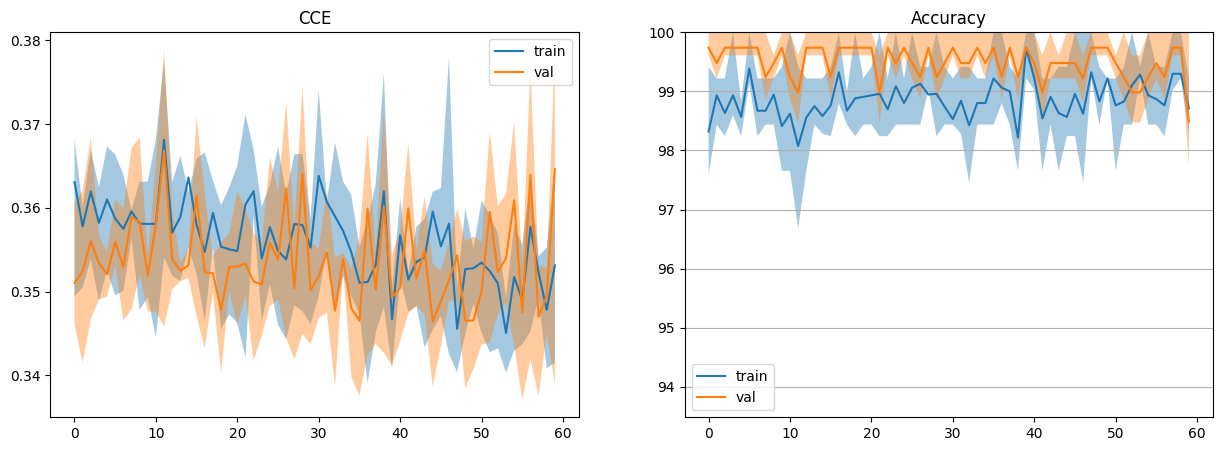

100%|██████████| 720/720 [00:00<00:00, 1497.21it/s]

Обучение закончено за 134.6734037399292 секунд


In [49]:
def train_classifier(
    model: nn.Module,
    learning_rate=5e-3,
    batch_size=128,
    epochs=EPOCHS,
    momentum=0.9,
    # Регуляризация модели за счёт коэффициента, учитывающего сложность модели.
    # Норма параметров будет прибавлена к функции потерь. Чем больше
    # weight_decay, тем сильнее штраф за сложность.
    weight_decay=1e-5,
    # Добавляем сглаживание целевых меток, это увеличит значение функции потерь
    #   но полученная модель будет более устойчивой к выбросам в обучающей выборке.
    label_smoothing=0.1,
    # Постепенное уменьшение шага обучения каждые N эпох.
    scheduler_step_size=240,
):
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.SGD(
        model.parameters(),
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay,
    )
    dataloader = create_dataloader(batch_size=batch_size)
    # Добавляем постепенное уменьшение шага обучения каждые step_size
    #   эпох.
    scheduler = optim.lr_scheduler.StepLR(
        optimizer=optimizer, step_size=scheduler_step_size, gamma=0.5
    )

    return train(
        model,
        criterion=criterion,
        optimizer=optimizer,
        dataloader=dataloader,
        epochs=epochs,
        scheduler=scheduler,
    )


dataloader = train_classifier(new_model)

### Проверка качества модели по классам на обучающей и тестовой выборках

In [46]:
def report_classification_results(dataloader: DataLoader):
    y_pred = []
    y_true = []
    with torch.no_grad():  # отключение автоматического дифференцирования
        for _, data in enumerate(dataloader, 0):
            inputs, labels = data
            # на GPU
            # inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(
            classification_report(
                y_true.argmax(axis=-1),
                y_pred.argmax(axis=-1),
                digits=4,
                target_names=list(map(str, CLASSES)),
            )
        )

In [47]:
def compare_classification_reports(dataloader: dict[str, DataLoader]):
    for part in ["train", "test"]:
        print(part)
        report_classification_results(dataloader[part])
        part != "test" and print("-" * 53)

In [50]:
compare_classification_reports(dataloader)

train
              precision    recall  f1-score   support

          17     0.9920    0.9960    0.9940       500
          70     0.9878    0.9720    0.9798       500
          35     0.9783    0.9900    0.9841       500

    accuracy                         0.9860      1500
   macro avg     0.9860    0.9860    0.9860      1500
weighted avg     0.9860    0.9860    0.9860      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       100
          70     0.9901    1.0000    0.9950       100
          35     1.0000    0.9900    0.9950       100

    accuracy                         0.9967       300
   macro avg     0.9967    0.9967    0.9967       300
weighted avg     0.9967    0.9967    0.9967       300



### Анализ результатов обучения модели
Как видно, результаты феноменальные. Мы достигли точности в 99,33%.

### Разморозим целиком модель

In [51]:
new_model = freeze(keep_last=66)  # More than total.
summary(new_model, input_size=(32, 32, 3))

	 1.conv1.weight
	 1.bn1.weight
	 1.bn1.bias
	 1.layer1.0.conv1.weight
	 1.layer1.0.bn1.weight
	 1.layer1.0.bn1.bias
	 1.layer1.0.conv2.weight
	 1.layer1.0.bn2.weight
	 1.layer1.0.bn2.bias
	 1.layer1.1.conv1.weight
	 1.layer1.1.bn1.weight
	 1.layer1.1.bn1.bias
	 1.layer1.1.conv2.weight
	 1.layer1.1.bn2.weight
	 1.layer1.1.bn2.bias
	 1.layer1.2.conv1.weight
	 1.layer1.2.bn1.weight
	 1.layer1.2.bn1.bias
	 1.layer1.2.conv2.weight
	 1.layer1.2.bn2.weight
	 1.layer1.2.bn2.bias
	 1.layer2.0.conv1.weight
	 1.layer2.0.bn1.weight
	 1.layer2.0.bn1.bias
	 1.layer2.0.conv2.weight
	 1.layer2.0.bn2.weight
	 1.layer2.0.bn2.bias
	 1.layer2.0.downsample.0.weight
	 1.layer2.0.downsample.1.weight
	 1.layer2.0.downsample.1.bias
	 1.layer2.1.conv1.weight
	 1.layer2.1.bn1.weight
	 1.layer2.1.bn1.bias
	 1.layer2.1.conv2.weight
	 1.layer2.1.bn2.weight
	 1.layer2.1.bn2.bias
	 1.layer2.2.conv1.weight
	 1.layer2.2.bn1.weight
	 1.layer2.2.bn1.bias
	 1.layer2.2.conv2.weight
	 1.layer2.2.bn2.weight
	 1.layer2.2.bn2

Эпоха: 60
Лучшая доля правильных ответов: 99.47916666666667
Текущая доля правильных ответов: 98.95833333333333




100%|██████████| 720/720 [02:06<00:00,  5.71it/s]


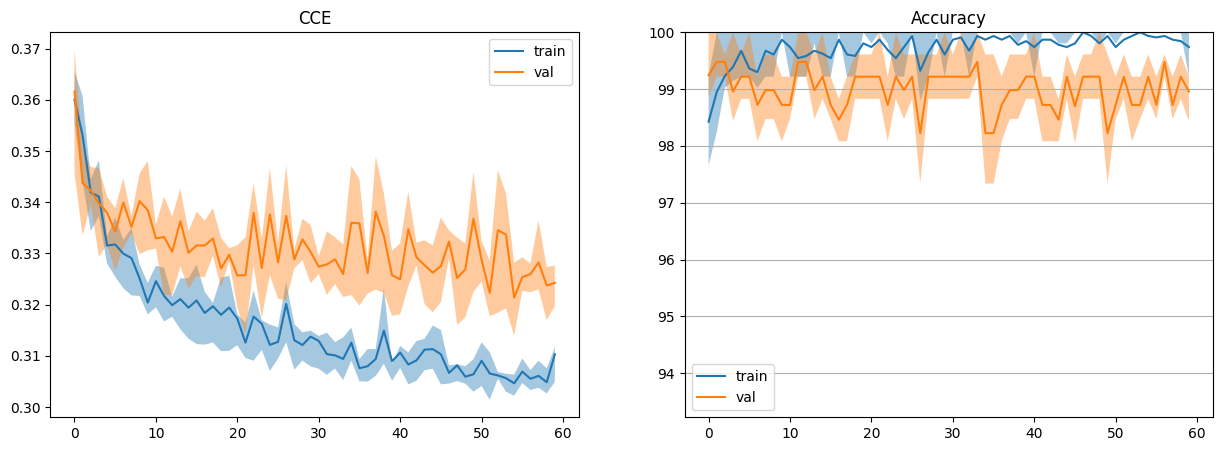

100%|██████████| 720/720 [00:00<00:00, 1372.43it/s]

Обучение закончено за 338.9737346172333 секунд
train


              precision    recall  f1-score   support

          17     0.9940    0.9960    0.9950       500
          70     0.9960    0.9920    0.9940       500
          35     0.9980    1.0000    0.9990       500

    accuracy                         0.9960      1500
   macro avg     0.9960    0.9960    0.9960      1500
weighted avg     0.9960    0.9960    0.9960      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       100
          70     0.9900    0.9900    0.9900       100
          35     0.9900    0.9900    0.9900       100

    accuracy                         0.9933       300
   macro avg     0.9933    0.9933    0.9933       300
weighted avg     0.9933    0.9933    0.9933       300



In [52]:
dataloader = train_classifier(new_model)
compare_classification_reports(dataloader)

Попробуем подобрать оптимальный параметр `keep_last`.

In [53]:
new_model = freeze(keep_last=10)  # More than total.
summary(new_model, input_size=(32, 32, 3))

	 1.layer3.1.bn2.weight
	 1.layer3.1.bn2.bias
	 1.layer3.2.conv1.weight
	 1.layer3.2.bn1.weight
	 1.layer3.2.bn1.bias
	 1.layer3.2.conv2.weight
	 1.layer3.2.bn2.weight
	 1.layer3.2.bn2.bias
	 1.fc.weight
	 1.fc.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlo

Эпоха: 60
Лучшая доля правильных ответов: 99.73958333333333
Текущая доля правильных ответов: 98.9820073445638




100%|██████████| 720/720 [00:51<00:00, 13.85it/s]


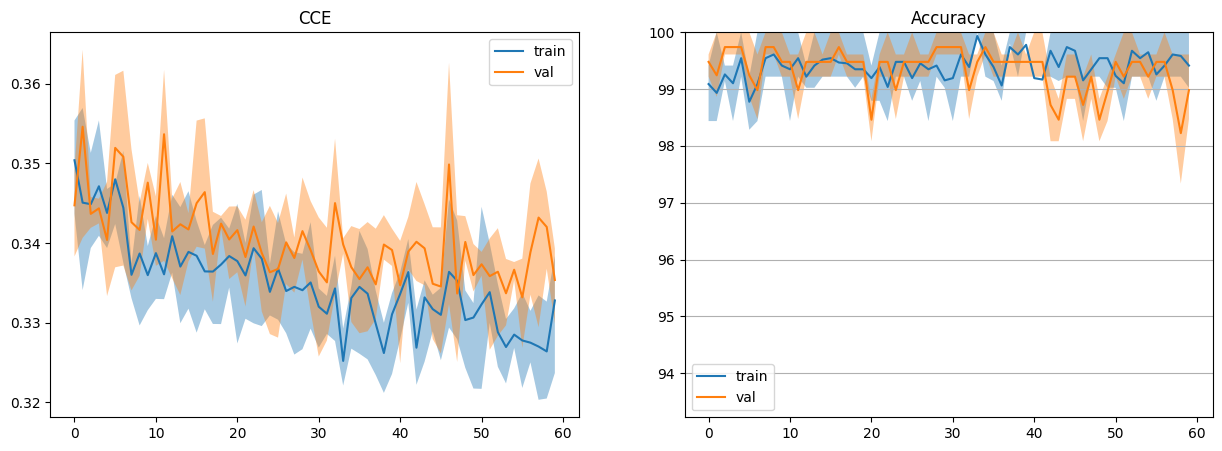

100%|██████████| 720/720 [00:00<00:00, 1618.70it/s]

Обучение закончено за 167.05213809013367 секунд
train


              precision    recall  f1-score   support

          17     0.9960    0.9960    0.9960       500
          70     0.9960    0.9960    0.9960       500
          35     0.9960    0.9960    0.9960       500

    accuracy                         0.9960      1500
   macro avg     0.9960    0.9960    0.9960      1500
weighted avg     0.9960    0.9960    0.9960      1500

-----------------------------------------------------
test
              precision    recall  f1-score   support

          17     1.0000    1.0000    1.0000       100
          70     0.9901    1.0000    0.9950       100
          35     1.0000    0.9900    0.9950       100

    accuracy                         0.9967       300
   macro avg     0.9967    0.9967    0.9967       300
weighted avg     0.9967    0.9967    0.9967       300



In [54]:
dataloader = train_classifier(new_model)
compare_classification_reports(dataloader)

## Экспорт модели

In [59]:
model_path = Path("models")
model_filename = "cifar100_resnet.pt"

model_path.mkdir(exist_ok=True)

model_file_path = model_path / model_filename

torch.save(model, model_file_path)
# загрузка
new_model_2 = torch.load(model_file_path)
new_model_2.eval()

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [60]:
# входной тензор для модели
onnx_model_filename = "cifar100_resnet.onnx"
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = new_model(x)

# экспорт модели
torch.onnx.export(
    new_model,  # модель
    x,  # входной тензор (или кортеж нескольких тензоров)
    model_path
    / onnx_model_filename,  # куда сохранить (либо путь к файлу либо fileObject)
    export_params=True,  # сохраняет веса обученных параметров внутри файла модели
    opset_version=9,  # версия ONNX
    do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
    input_names=["input"],  # имя входного слоя
    output_names=["output"],  # имя выходного слоя
    dynamic_axes={
        "input": {
            0: "batch_size"
        },  # динамичные оси, в данном случае только размер пакета
        "output": {0: "batch_size"},
    },
)